In [1]:
import requests
import re
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import highlight_text as htext
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.font_manager
from PIL import Image
from io import BytesIO

In [187]:
# SET SEASON, WEEK, TEAM to be plotted
SEASON = 2022
WEEK = 6
TEAM = 'NYJ'

In [188]:
# get team info (colors, URLS, abbr., etc.)
df_teams_info = pd.read_csv("./data/team_logos.csv")

# get pbp_participation
df_par = pd.read_csv(f"https://github.com/nflverse/nflverse-data/releases/download/pbp_participation/pbp_participation_{SEASON}.csv")

# get play by play for season
cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam',
        'defteam',
        'game_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards'] #'qb_kneel','field_goal_attempt','TD_team','safety','penalty','fumble_lost','interception','fourth_down_failed']

df_pbp = nfl.import_pbp_data(years=[SEASON], columns=cols, downcast=True, cache=False)

2022 done.
Downcasting floats.


In [209]:
def get_offensive_drives(df=df_pbp, team=TEAM, week=WEEK):
    """
     filter play-by-play data by team, week, and notnull() valued downs
    """
    conditional_team = (df['posteam'] == team)
    conditional_week = (df['week'] == week)
    is_down = (df['down'].notnull())
    return df[conditional_team & conditional_week & is_down]


def get_teams(df):
    """
        return first listed home and away teams
        from list of unique team names in 
        the nflreadr play by play dataframe
    """
    home_team = df.home_team.unique()[0]
    away_team = df.away_team.unique()[0]
    return home_team, away_team


def get_team_info(df, team):
    """
        return info specific to the team
        from nflreadr teams dataframe
    """
    teamname = df[df['team_abbr'] == team].team_name.tolist()[0]
    team_nick = df[df['team_abbr'] == team].team_nick.tolist()[0]
    team_abbr = df[df['team_abbr'] == team].team_abbr.tolist()[0]
    logoURL = df[df['team_abbr'] == team].team_logo_wikipedia.tolist()[0]
    wordmarkURL = df[df['team_abbr'] == team].team_wordmark.tolist()[0]
    team_color1 = df[df['team_abbr'] == team].team_color.tolist()[0]
    team_color2 = df[df['team_abbr'] == team].team_color2.tolist()[0]
    team_color3 = df[df['team_abbr'] == team].team_color3.tolist()[0]
    return teamname, team_nick, team_abbr, logoURL, wordmarkURL, [team_color1, team_color2, team_color3]


def format_drive_result(drive_result):
    """
        format text that is important
        w/exclamation point + uppercase
    """
    if drive_result in ["Touchdown", "Opp touchdown"]:
        drive_result = drive_result + "!"
    return " " + drive_result.upper()


def merge_play_par(df_play, df_par):
    """
         utility function for merging the play-by-play dataframe and pbp_participation dataframe
    """
    return pd.merge(df_play, df_par, how='left', left_on=['game_id','play_id'], right_on=['nflverse_game_id','play_id'])


def extract_opersonnel(pers):
    """
        returns a dictionary of the offensive player personnel combination in the string `pers`
        ST = Special Teams
        OL = Offensive Linemen
        RB = Running Back
        TE = Tight End
        WR = Wide Receiver
    """
    re_ST_pattern = re.compile('(ST)')
    re_OL_pattern = re.compile('(\d) OL')
    re_RB_pattern = re.compile('(\d) RB')
    re_TE_pattern = re.compile('(\d) TE')
    re_WR_pattern = re.compile('(\d) WR')
    return {'ST':re_ST_pattern.findall(pers)[0] if len(re_ST_pattern.findall(pers)) == 1 else '',
           'OL':str(int(re_OL_pattern.findall(pers)[0])-5) if len(re_OL_pattern.findall(pers)) == 1 else '',
           'RB':re_RB_pattern.findall(pers)[0] if len(re_RB_pattern.findall(pers)) == 1 else '',
           'TE':re_TE_pattern.findall(pers)[0] if len(re_TE_pattern.findall(pers)) == 1 else '',
           'WR':re_WR_pattern.findall(pers)[0] if len(re_WR_pattern.findall(pers)) == 1 else ''}


def extract_dpersonnel(pers):
    """
        returns a dictionary of the defensive player personnel combination in the string `pers`
        ST = Special Teams
        DL = Defensive Linemen
        LB = Linebacker
        DB = Defensive Back
    """
    re_ST_pattern = re.compile('(ST)')
    re_DL_pattern = re.compile('(\d) DL')
    re_LB_pattern = re.compile('(\d) LB')
    re_DB_pattern = re.compile('(\d) DB')
    return {
           'DL':re_DL_pattern.findall(pers)[0] if len(re_DL_pattern.findall(pers)) == 1 else '',
           'LB':re_LB_pattern.findall(pers)[0] if len(re_LB_pattern.findall(pers)) == 1 else '',
           'DB':re_DB_pattern.findall(pers)[0] if len(re_DB_pattern.findall(pers)) == 1 else ''}


def create_subplot_structure(axd_idxs):
    """
        take the number of drives and build subplot structure for subplots_mosaic function
        return axs = [['header','playlist'],['header','1'],['header','2'],
                        ['header','3'],['header','halftime],['header','4'],
                        ['header',5'],[,'footer']]
        results in a plot of shape:
         _______________________
        |___header__|  playlist |
        |___1_______|           |
        |___2_______|           |
        |___3_______|           |
        |__halftime_|           |
        |___4_______|           |
        |___5_______|           |
        |________footer_________|
        
    """
    # initial empty subplot structure
    axs  = [['header','playlist']] 
    # create field subplot structure
    for axd_idx in axd_idxs:  
            subplot = [axd_idx,'playlist']
            axs.append(subplot)
    axs.append(['footer', 'footer'])
    return axs


def get_epa_minmax(df):
    return df.epa.min(),df.epa.max()


def get_drives_list(df):
    df_drives_results_halfs = df[['drive','fixed_drive_result','game_half']].drop_duplicates(['drive','fixed_drive_result'])
    drives = df_drives_results_halfs['drive'].tolist()
    return drives


def get_halfs_list(df):
    df_drives_results_halfs = df[['drive','fixed_drive_result','game_half']].drop_duplicates(['drive','fixed_drive_result'])
    game_halfs = df_drives_results_halfs['game_half'].tolist()
    return game_halfs


def make_axd_idxs(df):
    drives = get_drives_list(df)
    game_halfs = get_halfs_list(df)
    half_idx = game_halfs.index('Half2')
    axd_idxs = np.arange(1,len(drives)+1).tolist()
    axd_idxs.insert(half_idx, '[  halftime  ]')
    try:
        overtime_idx = game_halfs.index('Overtime')
        axd_idxs.insert(overtime_idx, '[  overtime  ]')
    except ValueError:
        print("no overtime period drives detected in this game")
    return axd_idxs
        

def make_height_ratios(df):
    drives = get_drives_list(df)
    game_halfs = get_halfs_list(df)
    half_idx = game_halfs.index('Half2')
    height_ratios=[1]*(len(drives))
    height_ratios.insert(half_idx,0.1)
    try:
        overtime_idx = game_halfs.index('Overtime')
        height_ratios.insert(overtime_idx,0.1)
    except ValueError:
        print("no overtime period drives detected in this game")
    # add height_ratio for header
    height_ratios.insert(0,1)
    # add height_ratio for footer
    height_ratios.append(0.5)
    return height_ratios
    

def format_playtype(playtype):
    playtype_mapping = {'qb_kneel':'qb kneel','punt':'punt','pass':'pass','run':'run','field_goal':'FG',
                        'Encroachment':'offside',
                        'Chop Block':'chop block',
                        'Defensive Offside':'offside',
                        'Face Mask':'face mask',
                        'Unnecessary Roughness':'personal foul',
                        'Delay of Game':'delay',
                        'Defensive Pass Interference':'def. PI',
                        'Offensive Pass Interference':'off. PI',
                        'Offensive Holding':'off. holding',
                        'Defensive Holding':'def. holding',
                        'False Start':'false start',
                        'Roughing the Passer':'RTP',
                        'Neutral Zone Infraction':'offside'}
    return playtype_mapping[playtype]
    

In [210]:
# filter play by play data for offensive drives in SEASON by TEAM and WEEK
df_team_week_plays = get_offensive_drives(df_pbp, TEAM, WEEK)   

# get home & away team names for the game
home_team, away_team = get_teams(df_team_week_plays)

# get the team name, team nickname, team logo URL, team wordmark URL, and colors and for home/away
home_teamname, home_teamnick, home_teamabbr, home_logoURL, home_wordmarkURL, home_teamcolors = get_team_info(df_teams_info, home_team)
away_teamname, away_teamnick, away_teamabbr, away_logoURL, away_wordmarkURL, away_teamcolors = get_team_info(df_teams_info, away_team)

In [211]:
df_play_par = merge_play_par(df_team_week_plays, df_par)
df_play_par.loc[df_play_par['offense_personnel'].isnull(), 'offense_personnel'] = 'ST'
df_play_par.loc[df_play_par['defense_personnel'].isnull(), 'defense_personnel'] = 'ST'
df_play_par = df_play_par.merge(pd.DataFrame.from_records(df_play_par['offense_personnel'].apply(extract_opersonnel)), how='left', left_index=True, right_index=True)
df_play_par = df_play_par.merge(pd.DataFrame.from_records(df_play_par['defense_personnel'].apply(extract_dpersonnel)), how='left', left_index=True, right_index=True)

In [212]:
# adjust coloring of downs?
# How do I want to convey personnel, down and distance, results of drive?



# FONT FAMILY
# add font family
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-light.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-black.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-roman.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bebas_Neue/BebasNeue-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bangers/Bangers-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Contrail_One/ContrailOne-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Permanent_Marker/PermanentMarker-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Righteous/Righteous-Regular.ttf')
# assign name of font family
azkidenz_text = "AkzidenzGrotesk"
bebas_text =  "Bebas Neue"
loma_text = "Loma"
bangers_text = "Bangers"
contrail_text = "Contrail One"
goldman_text = "Goldman"
pm_text = "Permanent Marker"
righteous_text = "Righteous"
ubuntuc_text = "Ubuntu Condensed"
padaukb_text = "Padauk Book"

# ASSIGN FONT FAMILY TO PLOT'S TEXT
title_text = bebas_text
subtitle_text = padaukb_text #ubuntuc_text
axs_label_text = contrail_text
axs_title_text = bebas_text
touchdown_text = bangers_text
drive_result_text = contrail_text
credits_text = goldman_text


# ALTERNATIVE COLOR
background ="#2E2C31"#"#444148" #"#808B96" straw"#e0dfd5"
text_color = "#ffefdd"#"#f4e5d3"
title_color = "#fff5ea"
axs_title_color = "#fff5ea"#"#DB3a34"#"#7cc6fe"#"#7cc6fe"
axs_title2_color = "#ffefdd"
axs_label_color = "#7cc6fe"#"#FFC53A"
credits_text_color = text_color
spines_color = "lightgrey"
grid_color = "lightgrey"
filler_color = "white"#DE584D"#"#138bdd"
drive_start_color = "#7cc6fe"#"#ee2e31"
drive_end_color = drive_start_color
drive_result_path_color = "black"
scatter_ec = "black"#"#fab2ea"#"#b37ba4"#"#e7e7e7"#"#2D1561"
color_list = ["#725ac1","#fdf6ee","#21a179"]#"#3650a0", #grapefruit"#c76e70" #raspberry"#A40E5B"["#CA1809","white","#48BDFF"]["#CA1809","white","#a9a9e5"] ["#b4869f","#ebf2fa","#a5be00"] ["#a06cd5","#ebf2fa","#cff27e"]["#8d89a6","#fdf6ee","#21a179"]
color_map = mpl.colors.LinearSegmentedColormap.from_list("custom_lin_colormap", color_list, N=256)
playlist_alt_color = "#986c6a"
playlist_text_color = text_color
penalty_color = "#FFC53A"
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
# flag_color = "#fdfb82"

# # ALTERNATIVE COLOR 1
# background ="#262626"
# text_color = "#F3F2EE"
# grid_color = "#838383"
# filler_color = "#DE584D"
# drive_start_color = "#CA1809"
# drive_end_color = "#CA1809"
# scatter_ec = "#CDD6D6"
# color_list =  ["#F0566D","#3299e4"]
# color_map = mpl.colors.LinearSegmentedColormap.from_list("custom_lin_colormap", color_list, N=256)
# playlist_alt_color = "#452c3c"
# playlist_text_color = "#F3F2EE"
# mpl.rcParams['xtick.color'] = text_color
# mpl.rcParams['ytick.color'] = text_color

# # COLOR
# background = "#343434"#"#444148" 
# text_color = "#F8F9F9"
# grid_color = "#838383"
# filler_color = "grey"
# drive_start_color = "lightgrey"
# drive_end_color = "lightgrey"
# color_map = "Spectral"
# mpl.rcParams['xtick.color'] = text_color
# mpl.rcParams['ytick.color'] = text_color
# flag_color = "#fdfb82", "#E0CA3C", "#E6C229"

# TEXT
title = "Overview:  {}' Offensive Drives\n<NFL {} WEEK {}>    <{}> <@> <{}>"
drive_title = "drive no.{}"
credits = "created: keegan heilman //  @keeganheilman\ndata: nflverse (https://github.com/nflverse) via nfl_data_py (https://github.com/cooperdff/nfl_data_py)"

# PLAYLIST TABLE DISTANCES
tbl_dist_left_margin = 0.5
tbl_dist_btwn_cols = 0.5
down_factor = 0.5
ytg_factor = 1
playtype_factor = 1
epa_factor = 1
opers_factor = 0.5
ST_factor = 1
dpers_factor = 0.5
tbl_down_dist = 1
tbl_ytg_dist = 0.8
tbl_playtype_dist = 2
tbl_epa_dist = 2.9
tbl_opers_dist = 7.5
tbl_ST_dist = -.2
tbl_dpers_dist = 7.5
tbl_halign = 'center'

# FONT DICTIONARY
tbl_hdr_fontdict = {'family': bebas_text,
        'color': text_color,
        'weight': 'bold',
        'size': 18,}
tbl_result_fontdict = {'family': bangers_text,
        'size': 16}
tbl_fontdict = {'family': loma_text,
        'color': playlist_text_color,
        'size': 12}
tbl_epa_fontdict = {'family': loma_text,
        'color': "black",
        'size': 12}

no overtime period drives detected in this game
no overtime period drives detected in this game


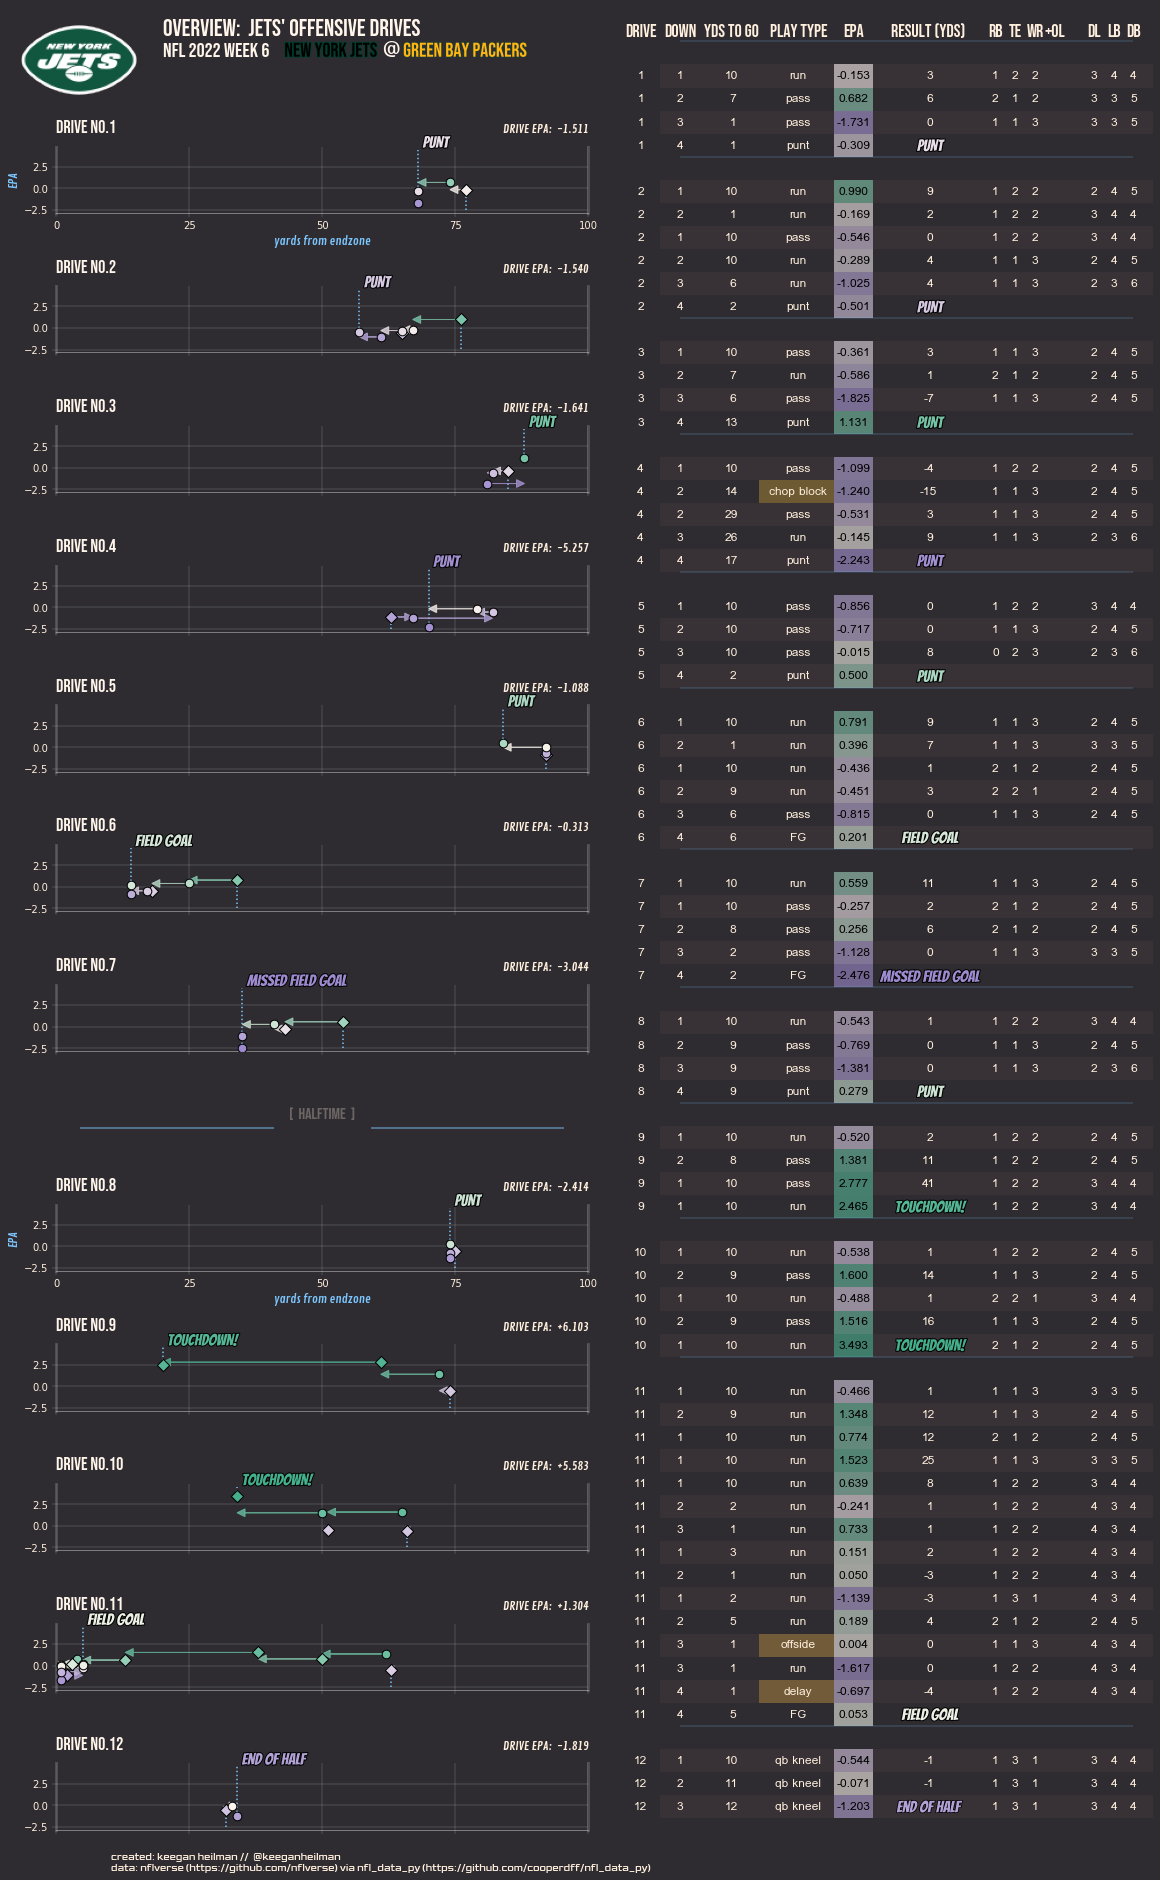

In [213]:
# build parameters for plotting
league_epa_min, league_epa_max = get_epa_minmax(df_pbp)
game_epa_min, game_epa_max = get_epa_minmax(df_play_par)
drives = get_drives_list(df_play_par)
axd_idxs = make_axd_idxs(df_play_par)
height_ratios = make_height_ratios(df_play_par)


# plot figure, axs
fig_height = round(24/11*len(drives))
gs_kw = dict(width_ratios=[1,1], height_ratios=height_ratios)
cmap = matplotlib.cm.get_cmap(color_map)
norm = mpl.colors.SymLogNorm(linthresh=0.75, vmin=league_epa_min, vmax=league_epa_max)
first_drive_of_half = True

# print(len(height_ratios), len(axs))
axs = create_subplot_structure(axd_idxs)
fig, axd = plt.subplot_mosaic(axs, gridspec_kw=gs_kw, figsize=(16,fig_height), layout="constrained")
fig.set_facecolor(background)

# add axis and plot logo
ax2 = fig.add_axes([0.015,0.92,0.10,0.10])
ax2.axis("off")
url = home_logoURL if TEAM == home_teamabbr else away_logoURL
response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)  

for k in axd:
    # is this the axis index of the header?
    if k == 'header':
        # set axis properties of header
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        # plot figure title
        team_nick = home_teamnick if TEAM == home_teamabbr else away_teamnick
        title_t = htext.ax_text(s=title.format(team_nick, SEASON, WEEK, away_teamname, home_teamname),
                       x=0.2,y=0.82, ax=axd[k],
                       highlight_textprops=[{"fontsize":20, "color": title_color},
                                            {"fontsize":20, "color": away_teamcolors[1], "path_effects":[path_effects.withStroke(linewidth=2, foreground=away_teamcolors[0])]},
                                            {"fontsize":20, "color": title_color, "fontfamily":subtitle_text},
                                            {"fontsize":20, "color": home_teamcolors[1], "path_effects":[path_effects.withStroke(linewidth=2, foreground=home_teamcolors[0])]}],
                       color=title_color,
                       fontsize=24,
                       fontfamily=title_text)

      
    
    # is this the axis index of the footer?
    elif k == 'footer':
        # set axis properties of footer
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        
        # add credits
        axd[k].text(0.05, 0.08,
         s=credits,
         fontstyle="italic",
         fontweight="light",
         fontsize=10,
         fontfamily=credits_text,
         color=credits_text_color)

    # is this the axis index of the playlist plot?
    elif k == 'playlist':
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        cols = ['drive','epa','down','ydstogo','epa','RB','TE','WR','OL','ST','DL','LB','DB']
        nrows =  df_play_par.shape[0]
        ncols =  df_play_par[cols].shape[1]

        axd[k].set_ylim(nrows+len(drives), -2)
        axd[k].set_xlim(0, ncols + .5)

        # plot rows of plays
        row_idx = 0
        drive = 0
        drive_idx = 0
        
        
        # add headers
        axd[k].text(x=0+tbl_dist_left_margin, y=-1, s="drive", va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(1*down_factor)+tbl_down_dist, y=-1, s='down', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(2*ytg_factor)+tbl_ytg_dist, y=-1, s='yds to go', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(2.5*playtype_factor)+tbl_playtype_dist, y=-1, s="play type", va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(3*epa_factor)+tbl_epa_dist, y=-1, s="EPA", va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(4*opers_factor)+tbl_opers_dist, y=-1, s='RB', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(5*opers_factor)+tbl_opers_dist, y=-1, s='TE', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(6*opers_factor)+tbl_opers_dist, y=-1, s='WR', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(7*opers_factor)+tbl_opers_dist, y=-1, s='+OL', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=-1, s='RESULT (yds)', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(9*dpers_factor)+tbl_dpers_dist, y=-1, s='DL', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(10*dpers_factor)+tbl_dpers_dist, y=-1, s='LB', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(11*dpers_factor)+tbl_dpers_dist, y=-1, s='DB', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        
        for df_idx, row in df_play_par.iterrows():
            if (row['drive'] != drive):
                axd[k].hlines(xmin=(1*down_factor)+tbl_down_dist, xmax=ncols, y=row_idx-0.5, linestyles="solid",color=drive_start_color,alpha=0.2)
                row_idx+=1
                drive_idx+=1
                drive = row['drive']
            
            cmap_point_color = (cmap(norm(row['epa'])))
            axd[k].text(x=0+tbl_dist_left_margin, y=row_idx, s=f"{drive_idx:.0f}", va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(1*down_factor)+tbl_down_dist, y=row_idx, s=str(int(row['down'])), va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(2*ytg_factor)+tbl_ytg_dist, y=row_idx, s=f"{row['ydstogo']:2.0f}", va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            # plot penalty type
            if row['play_type'] == 'no_play':
                    playtype = row['penalty_type']
                    # axd[k].text(x=(2.5*playtype_factor)+tbl_playtype_dist, y=row_idx, s= , va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            else:
                playtype = row['play_type']
            axd[k].text(x=(2.5*playtype_factor)+tbl_playtype_dist, y=row_idx, s=format_playtype(playtype), va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(3*epa_factor)+tbl_epa_dist, y=row_idx, s= f"{row['epa']:.3f}", va='center', ha=tbl_halign, fontdict=tbl_epa_fontdict)
            axd[k].text(x=(4*opers_factor)+tbl_opers_dist, y=row_idx, s=row['RB'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(5*opers_factor)+tbl_opers_dist, y=row_idx, s=row['TE'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(6*opers_factor)+tbl_opers_dist, y=row_idx, s=row['WR'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(7*opers_factor)+tbl_opers_dist, y=row_idx, s=row['OL'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            try:
                if df_play_par.loc[df_idx+1]['drive'] != drive:
                    t = axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=format_drive_result(row['fixed_drive_result']), va='center', ha=tbl_halign, fontdict=tbl_result_fontdict, color=cmap_point_color)
                    t.set_path_effects([path_effects.withStroke(linewidth=2, foreground=drive_result_path_color)])
                elif row['play_type'] == 'no_play':
                    if row['penalty_team'] != TEAM:
                        penalty_yards = int(row['penalty_yards'])
                    else:
                        penalty_yards = -1*int(row['penalty_yards'])
                    t= axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=f"{penalty_yards:2.0f}", va='center', ha=tbl_halign, fontdict=tbl_fontdict)
                    rect = mpl.patches.Rectangle(((2.5*playtype_factor+tbl_playtype_dist)-1,row_idx-0.5),width=1.9, height=1, ec=None,fc=penalty_color, alpha=0.3)
                    axd[k].add_patch(rect)
                else:
                    t= axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=f"{row['yards_gained']:2.0f}", va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            except KeyError:
                t = axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=row['fixed_drive_result'], va='center', ha=tbl_halign, fontdict=tbl_result_fontdict, color=cmap_point_color)
                t.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground=drive_result_path_color)])
            axd[k].text(x=(9*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['DL'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(10*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['LB'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(11*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['DB'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            if df_idx % 2 == 0:
                rect = mpl.patches.Rectangle((((1*down_factor)+tbl_down_dist-0.5),row_idx-0.5),width=ncols, height=1, ec=None,fc=playlist_alt_color, alpha=0.1)
                axd[k].add_patch(rect)
            rect = mpl.patches.Rectangle(((3*epa_factor)+tbl_epa_dist-tbl_dist_btwn_cols,row_idx-0.5),width=(tbl_dist_btwn_cols*2), height=1, ec=None,fc=cmap_point_color, alpha=0.6)
            axd[k].add_patch(rect)
            # axd[k].hlines(xmin=(1*down_factor)+tbl_down_dist-0.5, xmax=ncols, y=row_idx+0.5, linestyles="dotted", color='lightgrey', lw=0.2)
            row_idx+=1           
        

    # is this the axis index of either halftime or overtime plot?
    elif k in ['[  halftime  ]','[  overtime  ]']:
        axd[k].patch.set_facecolor(background)
        axd[k].set_title(label=k, color=text_color, fontweight="light", fontfamily=axs_title_text, fontsize=16, alpha=0.3)
        axd[k].axis("off")
        axd[k].hlines(y=[-1], xmin=0, xmax=40, colors=[drive_start_color],linestyles="solid", alpha=0.6)
        axd[k].hlines(y=[-1], xmin=60, xmax=100, colors=[drive_start_color],linestyles="solid", alpha=0.6)
        first_drive_of_half = True
        
    # is this the axis index of a drive to be plotted?
    else:
        # initialize which drive it is
        drive = drives[0]
        drives.pop(0)
        
        # obtain values for text
        drive_result = df_team_week_plays[df_team_week_plays.drive == drive].fixed_drive_result.unique().tolist()[0]
        
        # assign x,y coordinates (yardline_100 and epa)
        x = df_team_week_plays[df_team_week_plays.drive == drive].yardline_100.tolist()
        y = df_team_week_plays[df_team_week_plays.drive == drive].epa.tolist()
        
        #  set properties of axis
        axd[k].patch.set_facecolor(background)
        axd[k].grid(ls="-", lw=0.2, color=grid_color, zorder=-10)
        axd[k].set_title(drive_title.format(k),pad=14,loc="left", color=axs_title_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
        axd[k].set_xlim(0,100)
        if not first_drive_of_half:
            axd[k].set_xticklabels([])
        else: 
            axd[k].set_xlabel("yards from endzone",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
            axd[k].set_ylabel("EPA",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
        axd[k].tick_params(axis="both",length=4, width=0.2, color=grid_color)
        axd[k].xaxis.set_major_locator(plt.MaxNLocator(4))
      
        spines = ["top", "right", "bottom", "left"]
        for s in spines:
            if s in ["top"]:
                axd[k].spines[s].set_visible(False)
            elif s in ["left", "right"]:
                axd[k].spines[s].set_color(spines_color)
                axd[k].spines[s].set_linewidth(3)
                axd[k].spines[s].set_alpha(.2)
            else:
                axd[k].spines[s].set_color(spines_color)
                axd[k].spines[s].set_alpha(.6)
        
        # display TOTAL EPA
        if sum(y) >= 0:
            axd[k].set_title(f"DRIVE EPA:  +{sum(y):.3f}",pad=14,loc="right", color=axs_title2_color, fontweight="light", fontfamily=contrail_text, fontsize=12)
        else:
            axd[k].set_title(f"DRIVE EPA:  {sum(y):.3f}",pad=14,loc="right", color=axs_title2_color, fontweight="light", fontfamily=contrail_text, fontsize=12)
        # plot drive information
        for point_idx, (x_val, y_val) in enumerate(zip(x,y)):
            cmap_point_color = (cmap(norm(y_val)))
            if point_idx < len(x)-1:
                if point_idx == 0:
                    axd[k].vlines(x_val, ymin=game_epa_min, ymax=y_val, colors=[drive_start_color], linestyles="dotted")
                ar = axd[k].arrow(x_val,y_val,
                                  x[point_idx+1]-x_val,0,
                                  color=(cmap(norm(y[point_idx]))),
                                  shape="full",
                                  length_includes_head=True,
                                  head_width=0.9,
                                  head_length=1.5,
                                  capstyle="butt",
                                  alpha=0.8,
                                  lw=1,
                                  zorder=5)
            # plot end of drive information
            if point_idx == len(x)-1:
                # plot vertical line at end of drive point
                end_of_drive_line = axd[k].vlines(x_val, ymin=y_val,ymax=game_epa_max+1,
                                                          colors=[drive_end_color],
                                                          linestyles="dotted",
                                                          zorder=-5)
                end_of_drive_line.set_path_effects([path_effects.withStroke(linewidth=0, foreground="white")])
                # plot end of drive result text (e.g. "TOUCHDOWN!") 
                drive_result_t= axd[k].text(x=x_val+0.3,y=game_epa_max+1.2,
                                                        s=format_drive_result(drive_result),
                                                        color=cmap_point_color,
                                                        fontfamily=touchdown_text,
                                                        fontsize=16)
                drive_result_t.set_path_effects([path_effects.withStroke(linewidth=2, foreground=drive_result_path_color)])
            # plot play point x=epa, y=yardline_100
            markers=df_team_week_plays[df_team_week_plays.drive == drive].down.tolist()
            mapping= {1:'D',2:"o",3:"o",4:"o"}
            axd[k].scatter(x_val,y_val, color=cmap_point_color,edgecolors=scatter_ec,s=75, alpha=1,lw=1,zorder=10,  marker=mapping[markers[point_idx]])
            
            first_drive_of_half = False

plt.show()
# fig.savefig(f'{SEASON}-WEEK{WEEK}-{TEAM}.png',bbox_inches='tight', dpi=600)
# plt.close('all')


# How to better construct the rows of plays? What other information is pertinent?

In [214]:
# add legend
# display team scores and added points (total EPA on drive)
# display plays which are under certain win percentage
# EPA vs yds to go by down and personnel
# percentage of plays percentile of EPA by personnel team average against game) Were they held down in certain personnel?
# EPA per play distribution

In [215]:
df_play_par['penalty_type'].unique()

array([None, 'Chop Block', 'Illegal Block Above the Waist',
       'Unnecessary Roughness', 'Defensive Offside', 'Delay of Game'],
      dtype=object)

In [216]:
df_play_par['penalty_team']

0     None
1     None
2     None
3     None
4     None
      ... 
60     NYJ
61    None
62    None
63    None
64    None
Name: penalty_team, Length: 65, dtype: object

(array([0.43453145, 0.21726561, 0.        , 0.43453123, 0.86906291,
        0.43453129, 0.43453137, 0.21726567, 0.        , 0.21726567,
        0.21726567, 0.        , 0.        , 0.21726573, 0.43453123,
        0.        , 0.        , 0.        , 0.        , 0.21726561]),
 array([-1.8253413 , -1.5952084 , -1.3650753 , -1.1349424 , -0.90480936,
        -0.6746764 , -0.4445434 , -0.21441041,  0.01572258,  0.24585557,
         0.47598857,  0.70612156,  0.93625456,  1.1663876 ,  1.3965205 ,
         1.6266536 ,  1.8567865 ,  2.0869195 ,  2.3170526 ,  2.5471854 ,
         2.7773185 ], dtype=float32),
 <BarContainer object of 20 artists>)

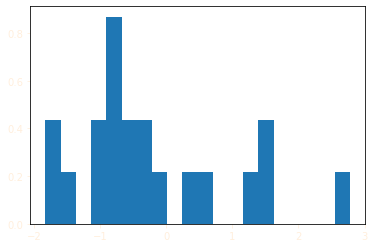

In [217]:
plt.hist(x=df_play_par[df_play_par.play_type=='pass'].epa,bins=20, density=True)

(array([2.45403636e-04, 2.45403636e-04, 0.00000000e+00, 2.45403775e-04,
        4.90807273e-04, 2.45403636e-03, 3.92646040e-03, 4.17186182e-03,
        2.45403706e-03, 1.79144705e-02, 1.27364514e-01, 5.49704262e-01,
        3.17061588e-01, 9.84068720e-02, 3.97554003e-02, 1.12885705e-02,
        3.43565188e-03, 1.71782545e-03, 1.47242265e-03, 4.90807273e-04]),
 array([-10.076398  ,  -9.230979  ,  -8.38556   ,  -7.5401416 ,
         -6.694723  ,  -5.849304  ,  -5.0038853 ,  -4.158467  ,
         -3.313048  ,  -2.4676292 ,  -1.6222105 ,  -0.77679175,
          0.06862698,   0.9140457 ,   1.7594645 ,   2.6048832 ,
          3.450302  ,   4.2957206 ,   5.1411395 ,   5.986558  ,
          6.831977  ], dtype=float32),
 <BarContainer object of 20 artists>)

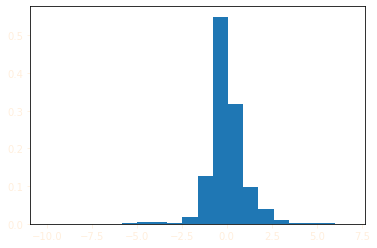

In [218]:
plt.hist(df_pbp[df_pbp.play_type=='run'].epa,bins=20, density=True)

no overtime period drives detected in this game
no overtime period drives detected in this game


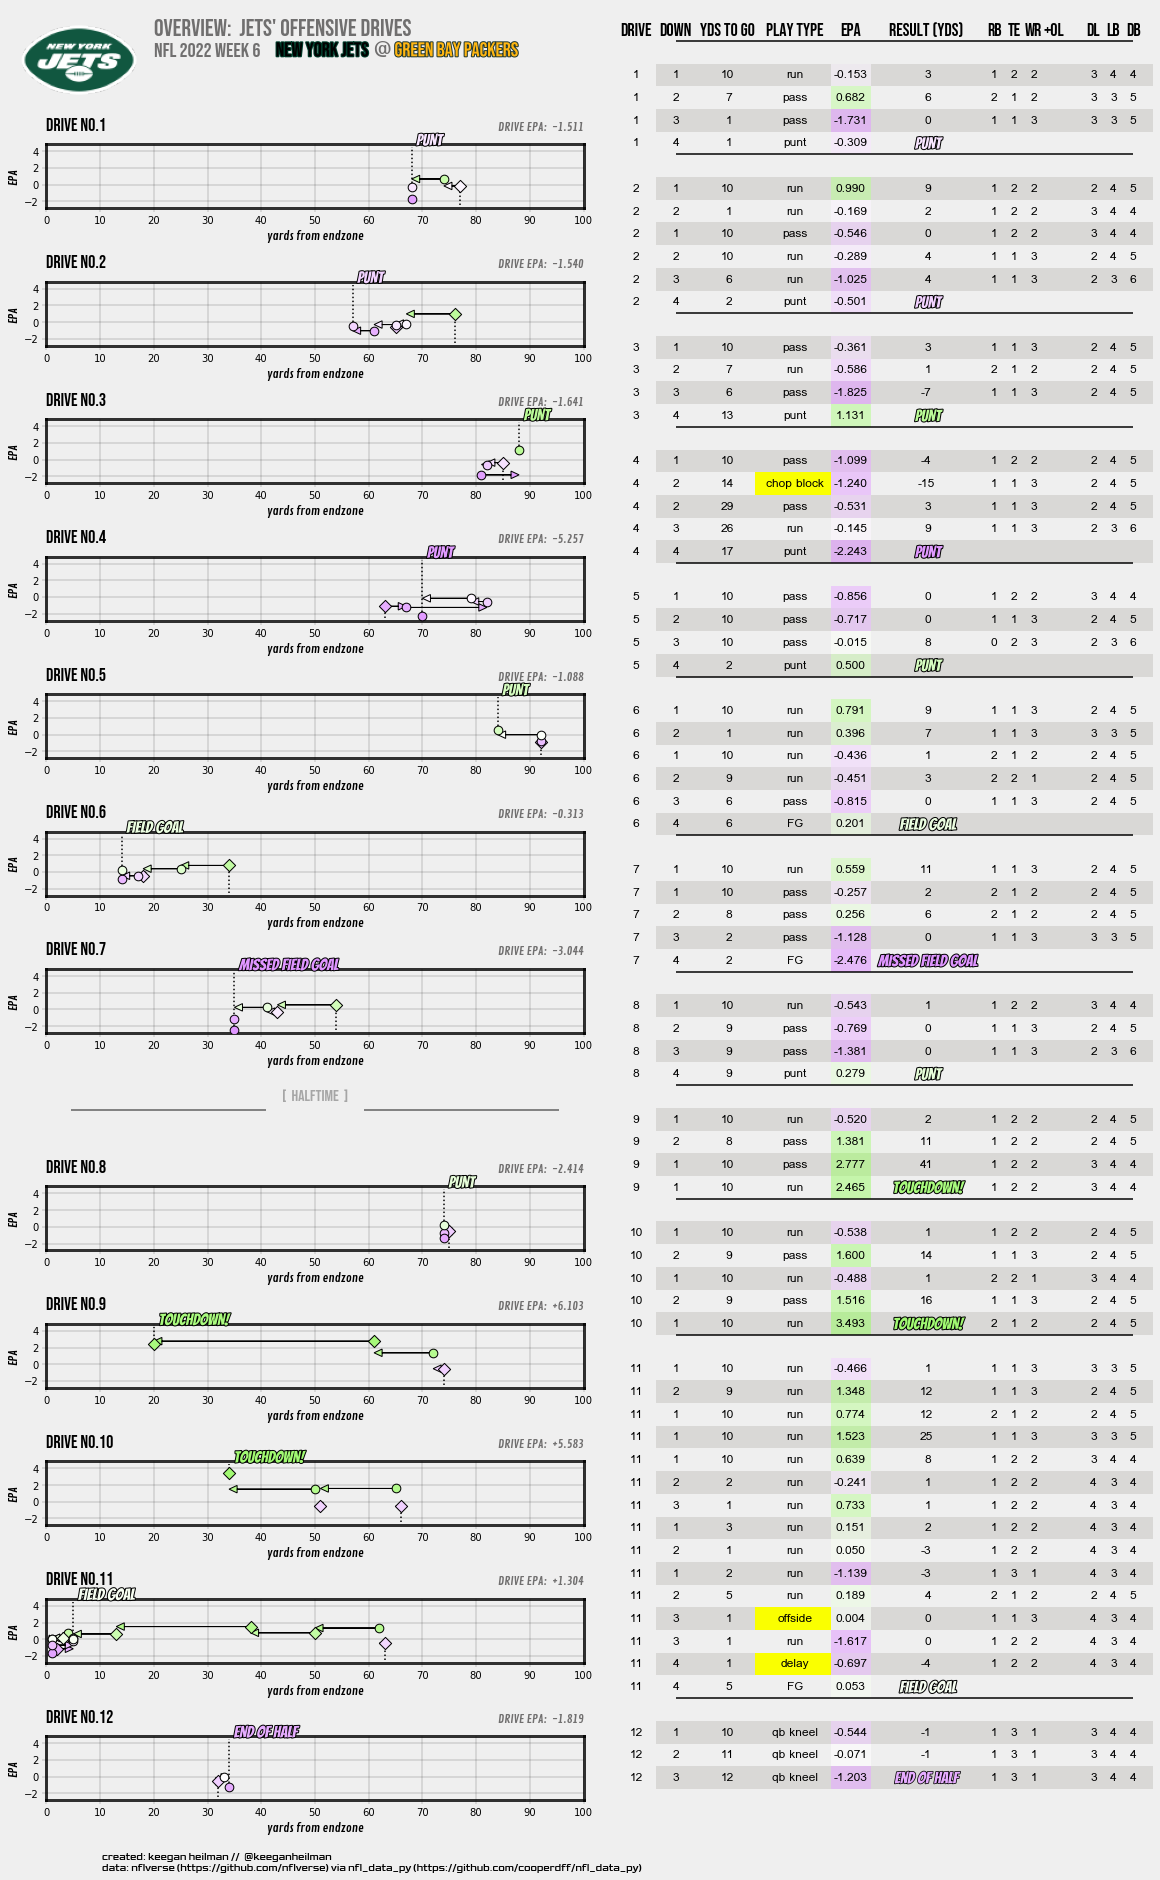

In [221]:
# TESTING ALTERNATIVE COLOR SCHEME

# ASSIGN FONT FAMILY TO PLOT'S TEXT
title_text = bebas_text
subtitle_text = padaukb_text #ubuntuc_text
axs_label_text = contrail_text
axs_title_text = bebas_text
touchdown_text = bangers_text
drive_result_text = contrail_text
credits_text = goldman_text


# ALTERNATIVE COLOR
background ="#efefef"#"#DBDBDB" #"#808B96" straw"#e0dfd5"
text_color = "black"
title_color = "#706f6f"
axs_title_color = "black"#"#ff1d15" #"#706f6f"#"#DB3a34"#"#7cc6fe"#"#7cc6fe"
axs_title2_color = "#706f6f"
axs_label_color = "black"#"#FFC53A"
credits_text_color = text_color
spines_color = "black"
grid_color = "black"
filler_color = "white"#DE584D"#"#138bdd"
drive_start_color = "black"
drive_end_color = drive_start_color
drive_result_path_color = "black"
scatter_ec = "black"#"#fab2ea"#"#b37ba4"#"#e7e7e7"#"#2D1561"
color_list = ["#d166ff","white","#8ff856"]#"#3650a0", #grapefruit"#c76e70" #raspberry"#A40E5B"["#CA1809","white","#48BDFF"]["#CA1809","white","#a9a9e5"] ["#b4869f","#ebf2fa","#a5be00"] ["#a06cd5","#ebf2fa","#cff27e"]["#8d89a6","#fdf6ee","#21a179"]
color_map = mpl.colors.LinearSegmentedColormap.from_list("custom_lin_colormap", color_list, N=256)
playlist_alt_color = "#191102"
playlist_text_color = text_color
penalty_color = "#faff00"
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
# flag_color = "#fdfb82"
# FONT DICTIONARY
tbl_hdr_fontdict = {'family': bebas_text,
        'color': text_color,
        'weight': 'bold',
        'size': 18,}
tbl_result_fontdict = {'family': bangers_text,
        'size': 16}
tbl_fontdict = {'family': loma_text,
        'color': playlist_text_color,
        'size': 12}
tbl_epa_fontdict = {'family': loma_text,
        'color': "black",
        'size': 12}



# build parameters for plotting
league_epa_min, league_epa_max = get_epa_minmax(df_pbp)
game_epa_min, game_epa_max = get_epa_minmax(df_play_par)
drives = get_drives_list(df_play_par)
axd_idxs = make_axd_idxs(df_play_par)
height_ratios = make_height_ratios(df_play_par)


# plot figure, axs
fig_height = round(24/11*len(drives))
gs_kw = dict(width_ratios=[1,1], height_ratios=height_ratios)
cmap = matplotlib.cm.get_cmap(color_map)
norm = mpl.colors.SymLogNorm(linthresh=0.75, vmin=league_epa_min, vmax=league_epa_max)
first_drive_of_half = True

# print(len(height_ratios), len(axs))
axs = create_subplot_structure(axd_idxs)
fig, axd = plt.subplot_mosaic(axs, gridspec_kw=gs_kw, figsize=(16,fig_height), layout="constrained")
fig.set_facecolor(background)

# add axis and plot logo
ax2 = fig.add_axes([0.015,0.92,0.10,0.10])
ax2.axis("off")
url = home_logoURL if TEAM == home_teamabbr else away_logoURL
response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)  

for k in axd:
    # is this the axis index of the header?
    if k == 'header':
        # set axis properties of header
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        # plot figure title
        team_nick = home_teamnick if TEAM == home_teamabbr else away_teamnick
        title_t = htext.ax_text(s=title.format(team_nick, SEASON, WEEK, away_teamname, home_teamname),
                       x=0.2,y=0.82, ax=axd[k],
                       highlight_textprops=[{"fontsize":20, "color": title_color},
                                            {"fontsize":20, "color": away_teamcolors[1], "path_effects":[path_effects.withStroke(linewidth=2, foreground=away_teamcolors[0])]},
                                            {"fontsize":20, "color": title_color, "fontfamily":subtitle_text},
                                            {"fontsize":20, "color": home_teamcolors[1], "path_effects":[path_effects.withStroke(linewidth=2, foreground=home_teamcolors[0])]}],
                       color=title_color,
                       fontsize=24,
                       fontfamily=title_text)

      
    
    # is this the axis index of the footer?
    elif k == 'footer':
        # set axis properties of footer
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        
        # add credits
        axd[k].text(0.05, 0.08,
         s=credits,
         fontstyle="italic",
         fontweight="light",
         fontsize=10,
         fontfamily=credits_text,
         color=credits_text_color)

    # is this the axis index of the playlist plot?
    elif k == 'playlist':
        axd[k].patch.set_facecolor(background)
        axd[k].axis("off")
        cols = ['drive','epa','down','ydstogo','epa','RB','TE','WR','OL','ST','DL','LB','DB']
        nrows =  df_play_par.shape[0]
        ncols =  df_play_par[cols].shape[1]

        axd[k].set_ylim(nrows+len(drives), -2)
        axd[k].set_xlim(0, ncols + .5)

        # plot rows of plays
        row_idx = 0
        drive = 0
        drive_idx = 0
        
        
        # add headers
        axd[k].text(x=0+tbl_dist_left_margin, y=-1, s="drive", va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(1*down_factor)+tbl_down_dist, y=-1, s='down', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(2*ytg_factor)+tbl_ytg_dist, y=-1, s='yds to go', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(2.5*playtype_factor)+tbl_playtype_dist, y=-1, s="play type", va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(3*epa_factor)+tbl_epa_dist, y=-1, s="EPA", va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(4*opers_factor)+tbl_opers_dist, y=-1, s='RB', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(5*opers_factor)+tbl_opers_dist, y=-1, s='TE', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(6*opers_factor)+tbl_opers_dist, y=-1, s='WR', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(7*opers_factor)+tbl_opers_dist, y=-1, s='+OL', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=-1, s='RESULT (yds)', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(9*dpers_factor)+tbl_dpers_dist, y=-1, s='DL', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(10*dpers_factor)+tbl_dpers_dist, y=-1, s='LB', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        axd[k].text(x=(11*dpers_factor)+tbl_dpers_dist, y=-1, s='DB', va='center', ha=tbl_halign, fontdict=tbl_hdr_fontdict)
        
        for df_idx, row in df_play_par.iterrows():
            if (row['drive'] != drive):
                axd[k].hlines(xmin=(1*down_factor)+tbl_down_dist, xmax=ncols, y=row_idx-0.5, linestyles="solid",color=drive_start_color,alpha=1)
                row_idx+=1
                drive_idx+=1
                drive = row['drive']
            
            cmap_point_color = (cmap(norm(row['epa'])))
            axd[k].text(x=0+tbl_dist_left_margin, y=row_idx, s=f"{drive_idx:.0f}", va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(1*down_factor)+tbl_down_dist, y=row_idx, s=str(int(row['down'])), va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(2*ytg_factor)+tbl_ytg_dist, y=row_idx, s=f"{row['ydstogo']:2.0f}", va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            # plot penalty type
            if row['play_type'] == 'no_play':
                    playtype = row['penalty_type']
                    # axd[k].text(x=(2.5*playtype_factor)+tbl_playtype_dist, y=row_idx, s= , va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            else:
                playtype = row['play_type']
            axd[k].text(x=(2.5*playtype_factor)+tbl_playtype_dist, y=row_idx, s=format_playtype(playtype), va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(3*epa_factor)+tbl_epa_dist, y=row_idx, s= f"{row['epa']:.3f}", va='center', ha=tbl_halign, fontdict=tbl_epa_fontdict)
            axd[k].text(x=(4*opers_factor)+tbl_opers_dist, y=row_idx, s=row['RB'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(5*opers_factor)+tbl_opers_dist, y=row_idx, s=row['TE'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(6*opers_factor)+tbl_opers_dist, y=row_idx, s=row['WR'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(7*opers_factor)+tbl_opers_dist, y=row_idx, s=row['OL'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            try:
                if df_play_par.loc[df_idx+1]['drive'] != drive:
                    t = axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=format_drive_result(row['fixed_drive_result']), va='center', ha=tbl_halign, fontdict=tbl_result_fontdict, color=cmap_point_color)
                    t.set_path_effects([path_effects.withStroke(linewidth=2, foreground=drive_result_path_color)])
                elif row['play_type'] == 'no_play':
                    if row['penalty_team'] != TEAM:
                        penalty_yards = int(row['penalty_yards'])
                    else:
                        penalty_yards = -1*int(row['penalty_yards'])
                    t= axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=f"{penalty_yards:2.0f}", va='center', ha=tbl_halign, fontdict=tbl_fontdict)
                    rect = mpl.patches.Rectangle(((2.5*playtype_factor+tbl_playtype_dist)-1,row_idx-0.5),width=1.9, height=1, ec=None,fc=penalty_color, alpha=1, zorder=-8)
                    axd[k].add_patch(rect)
                else:
                    t= axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=f"{row['yards_gained']:2.0f}", va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            except KeyError:
                t = axd[k].text(x=(8*ST_factor)+tbl_ST_dist, y=row_idx, s=row['fixed_drive_result'], va='center', ha=tbl_halign, fontdict=tbl_result_fontdict, color=cmap_point_color)
                t.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground=drive_result_path_color)])
            axd[k].text(x=(9*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['DL'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(10*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['LB'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            axd[k].text(x=(11*dpers_factor)+tbl_dpers_dist, y=row_idx, s=row['DB'], va='center', ha=tbl_halign, fontdict=tbl_fontdict)
            if df_idx % 2 == 0:
                rect = mpl.patches.Rectangle((((1*down_factor)+tbl_down_dist-0.5),row_idx-0.5),width=ncols, height=1, ec=None,fc=playlist_alt_color, alpha=0.1, zorder=-9)
                axd[k].add_patch(rect)
            rect = mpl.patches.Rectangle(((3*epa_factor)+tbl_epa_dist-tbl_dist_btwn_cols,row_idx-0.5),width=(tbl_dist_btwn_cols*2), height=1, ec=None,fc=cmap_point_color, alpha=0.6)
            axd[k].add_patch(rect)
            # axd[k].hlines(xmin=(1*down_factor)+tbl_down_dist-0.5, xmax=ncols, y=row_idx+0.5, linestyles="dotted", color='lightgrey', lw=0.2)
            row_idx+=1           
        

    # is this the axis index of either halftime or overtime plot?
    elif k in ['[  halftime  ]','[  overtime  ]']:
        axd[k].patch.set_facecolor(background)
        axd[k].set_title(label=k, color=text_color, fontweight="light", fontfamily=axs_title_text, fontsize=16, alpha=0.3)
        axd[k].axis("off")
        axd[k].hlines(y=[-1], xmin=0, xmax=40, colors=[drive_start_color],linestyles="solid", alpha=0.6)
        axd[k].hlines(y=[-1], xmin=60, xmax=100, colors=[drive_start_color],linestyles="solid", alpha=0.6)
        first_drive_of_half = True
        
    # is this the axis index of a drive to be plotted?
    else:
        # initialize which drive it is
        drive = drives[0]
        drives.pop(0)
        
        # obtain values for text
        drive_result = df_team_week_plays[df_team_week_plays.drive == drive].fixed_drive_result.unique().tolist()[0]
        
        # assign x,y coordinates (yardline_100 and epa)
        x = df_team_week_plays[df_team_week_plays.drive == drive].yardline_100.tolist()
        y = df_team_week_plays[df_team_week_plays.drive == drive].epa.tolist()
        
        #  set properties of axis
        axd[k].patch.set_facecolor(background)
        axd[k].grid(ls="-", lw=0.2, color=grid_color, zorder=-10)
        axd[k].set_title(drive_title.format(k),pad=14,loc="left", color=axs_title_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
        axd[k].set_xlim(0,100)
        if not first_drive_of_half:
            axd[k].set_xticklabels([])
        else: 
            axd[k].set_xlabel("yards from endzone",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
            axd[k].set_ylabel("EPA",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
        axd[k].tick_params(axis="both",length=4, width=0.2, color=grid_color)
        axd[k].xaxis.set_major_locator(plt.MaxNLocator(10))
        axd[k].yaxis.set_major_locator(plt.MaxNLocator(4))
      
        spines = ["top", "right", "bottom", "left"]
        for s in spines:
            if s in ["top"]:
                axd[k].spines[s].set_color(spines_color)
                axd[k].spines[s].set_linewidth(3)
                axd[k].spines[s].set_alpha(.8)
            elif s in ["left", "right"]:
                axd[k].spines[s].set_color(spines_color)
                axd[k].spines[s].set_linewidth(3)
                axd[k].spines[s].set_alpha(.8)
            else:
                axd[k].spines[s].set_color(spines_color)
                axd[k].spines[s].set_linewidth(3)
                axd[k].spines[s].set_alpha(.8)
        
        # display TOTAL EPA
        if sum(y) >= 0:
            axd[k].set_title(f"DRIVE EPA:  +{sum(y):.3f}",pad=14,loc="right", color=axs_title2_color, fontweight="light", fontfamily=contrail_text, fontsize=12)
        else:
            axd[k].set_title(f"DRIVE EPA:  {sum(y):.3f}",pad=14,loc="right", color=axs_title2_color, fontweight="light", fontfamily=contrail_text, fontsize=12)
        # plot drive information
        for point_idx, (x_val, y_val) in enumerate(zip(x,y)):
            cmap_point_color = (cmap(norm(y_val)))
            if point_idx < len(x)-1:
                if point_idx == 0:
                    axd[k].vlines(x_val, ymin=game_epa_min, ymax=y_val, colors=[drive_start_color], linestyles="dotted")
                ar = axd[k].arrow(x_val,y_val,
                                  x[point_idx+1]-x_val,0,
                                  facecolor=(cmap(norm(y[point_idx]))),
                                  edgecolor="black",
                                  shape="full",
                                  length_includes_head=True,
                                  head_width=0.9,
                                  head_length=1.5,
                                  capstyle="butt",
                                  alpha=1,
                                  lw=1,
                                  zorder=5)
            # plot end of drive information
            if point_idx == len(x)-1:
                # plot vertical line at end of drive point
                end_of_drive_line = axd[k].vlines(x_val, ymin=y_val,ymax=game_epa_max+1,
                                                          colors=[drive_end_color],
                                                          linestyles="dotted",
                                                          zorder=-5)
                end_of_drive_line.set_path_effects([path_effects.withStroke(linewidth=0, foreground="white")])
                # plot end of drive result text (e.g. "TOUCHDOWN!") 
                drive_result_t= axd[k].text(x=x_val+0.3,y=game_epa_max+1.2,
                                                        s=format_drive_result(drive_result),
                                                        color=cmap_point_color,
                                                        fontfamily=touchdown_text,
                                                        fontsize=16)
                drive_result_t.set_path_effects([path_effects.withStroke(linewidth=2, foreground=drive_result_path_color)])
            # plot play point x=epa, y=yardline_100
            markers=df_team_week_plays[df_team_week_plays.drive == drive].down.tolist()
            mapping= {1:'D',2:"o",3:"o",4:"o"}
            axd[k].scatter(x_val,y_val, color=cmap_point_color,edgecolors=scatter_ec,s=75, alpha=1,lw=1,zorder=10,  marker=mapping[markers[point_idx]])
            
            first_drive_of_half = True

plt.show()
# fig.savefig(f'{SEASON}-WEEK{WEEK}-{TEAM}.png',bbox_inches='tight', dpi=600)
# plt.close('all')


# How to better construct the rows of plays? What other information is pertinent?